# Identifying active irrigated cropping

* **Products used:** 
[ls8_st](https://explorer.digitalearth.africa/ls8_st), 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[crop_mask_sahel](https://explorer.digitalearth.africa/crop_mask_sahel), 
[ERA5 Climate Data](https://registry.opendata.aws/ecmwf-era5/)


## Background

One of the well-known measures of plant health is canopy temperature. In conditions with limited water, it can be assumed transpiration decreases and plant temperature subsequently increases. This can often happen during periods of moisture stress in dryland (rainfed) cropping systems but can be overcome by water application in irrigated cropping systems. 

In the field, canopy temperatures can be measured by handheld radiometers. This sort of data is used at a small scale to examine crop health and yield under a variety of conditions. At larger scales, an alternative method is to use surface temperature detected by satellites such as Landsat 8 to calculate similar metrics. In this notebook, we will use $\Delta T$ to differentiate between dryland and irrigated cropland, where $\Delta T$ is:

\begin{equation}
\Delta T = T_c - T_a
\end{equation}

where

* $T_c$ is crop canopy temperature
* $T_a$ is air temperature

Lower $\Delta T$ is associated with higher rates of transpiration as evaporative cooling from transpiration cools the canopy, while highter $\Delta T$ indicates lower rates of transpiration and thereby moisture stress.

In this case, we will use measurements of air temperature modelled by ERA5 to approximate $T_a$ and the Landsat surface temperature product to approximate $T_c$.

## Description
In this notebook, we calculate $\Delta T$  and visualise over irrigated areas.

The following steps are taken:

1. Load Landsat 8 Surface Temperature data
2. Load ERA5 "Air temperature at 2 metres" data for the same area of interest
3. Calculate $\Delta T$
4. Visualise $\Delta T$
5. Use a simple cluster analysis to differentiate between irrigated and dryland cropping.
6. Map irrigated cropping within the area of interest.

***

## Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from skimage.filters import threshold_li
from matplotlib.colors import ListedColormap

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_ST")

### Analysis parameters

This analysis focuses on cropland in Sudan. The western portion of the area of interest appear irrigated, as it is serviced by canals on close inspection, and vegetation is greener than surrounding landscape features. The eastern portion of the area is mostly dryland cropping.

In [3]:
lon = 33.822#-8.0766 #30.379 
lat = 13.8489#33.073
buffer = 0.125

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

time = ('2019-06', '2019-11')

measurements = ['surface_temperature']

### View selected location

In [4]:
display_map(lon_range, lat_range)

## Load Landsat 8 Surface Temperature data

In [5]:
ds_land = load_ard(dc=dc,
               products=['ls8_st'],
               x=lon_range,
               y=lat_range,
               time=time,
               measurements=measurements,
               skip_broken_datasets=True,
               output_crs='EPSG:6933',
               mask_filters=[("opening", 5),("dilation", 5)], #improve cloud-mask
               resolution=(-30, 30))

print(ds_land)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying morphological filters to pq mask [('opening', 5), ('dilation', 5)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:              (time: 24, y: 1034, x: 805)
Coordinates:
  * time                 (time) datetime64[ns] 2019-06-05T08:03:16.927509 ......
  * y                    (y) float64 1.766e+06 1.766e+06 ... 1.735e+06 1.735e+06
  * x                    (x) float64 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
    spatial_ref          int32 6933
Data variables:
    surface_temperature  (time, y, x) float32 nan nan nan ... 324.6 324.5 324.4
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Convert to celsius and resample to annual means

In [6]:
# convert from Kelvin to Celsius
ds_land['surface_temperature'] = ds_land.surface_temperature - 273.15

#Annual surface land temp
ds_land = ds_land.mean('time')

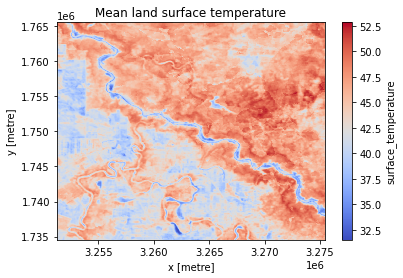

In [7]:
#plot
ds_land.surface_temperature.plot.imshow(cmap='coolwarm')
plt.title('Mean land surface temperature');

## Load ERA5 Air Temperature data

In [8]:
# load ERA5 air temperature at 2m height, resampled to daily means
var = 'air_temperature_at_2_metres'
ds_air = load_era5(var, lat_range, lon_range, time, resample='1M', reduce_func=np.mean)[var] - 273.15
ds_air = ds_air.compute() #bring into memory

#rename dimensions to match landsat
ds_air = ds_air.rename({'lon': 'x','lat': 'y'})

#Seasonal mean air temp
ds_air = ds_air.mean('time')

The above plots show the data has loaded correctly. ERA5 temporal resolution is higher than Landsat 8, which accounts for the greater fluctuation. It is also expected that land temperature will be higher than 2 metre air temperature. 

Note the land temperature estimated by Landsat 8 can seem quite high; here, it is shown in excess of 40 degrees Celsius. In this notebook, we do not have the means to validate the dataset so it is difficult to tell if the readings are accurate, or exaggerated due to inherent instrumentation error. Regardless, this is mitigated by $\Delta T$ which looks at the difference between temperatures instead of absolute values.

## Calculate Ts - Ta

As noted in the introduction, for this exercise we estimate $\Delta T$ using the loaded temperature datasets in lieu of in-situ data. This can be broken down into the following steps:

1. Reproject air temperature to match the resolution of Landsat
2. Find the difference ($\Delta T$) between $T_c$ (land temperature) and $T_a$ (air temperature)


In [9]:
ds_air = xr_reproject(src=ds_air, geobox=ds_land.geobox, resampling="nearest")

Calculate $\Delta T$:

In [10]:
deltat = ds_land.surface_temperature - ds_air

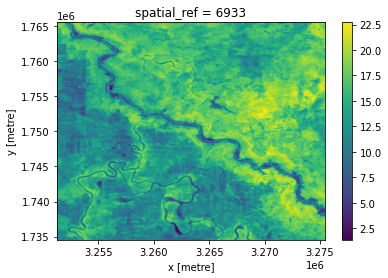

In [11]:
deltat.plot.imshow();

## Load Landsat-8 Surface Reflectance data and calculate NDVI

In [12]:
ds_ndvi = load_ard(dc=dc,
               products=['ls8_sr'],
               like=ds_land.geobox,
               time=time,
               skip_broken_datasets=True,
               measurements =['red', 'nir'])

ds_ndvi = calculate_indices(ds_ndvi, index='NDVI', collection = 'c2', drop=True)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps
Dropping bands ['red', 'nir']


In [13]:
ds_ndvi = ds_ndvi.max('time').squeeze()
print(ds_ndvi)

<xarray.Dataset>
Dimensions:      (y: 1034, x: 805)
Coordinates:
  * y            (y) float64 1.766e+06 1.766e+06 ... 1.735e+06 1.735e+06
  * x            (x) float64 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
    spatial_ref  int32 6933
Data variables:
    NDVI         (y, x) float32 0.219 0.2188 0.197 ... 0.3944 0.4339 0.5525


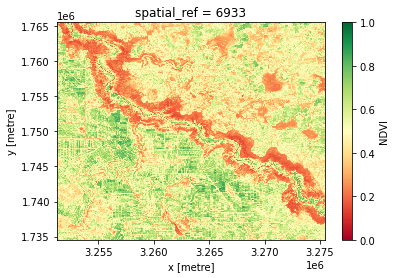

In [14]:
ds_ndvi.NDVI.plot.imshow(cmap='RdYlGn', vmin=0, vmax=1);

## Use the Cropland extent product for masking cropping regions

We can use $\Delta T$ to differentiate between irrigated and dryland cropping, but to do this we need to restrict our analysis to cropland and exclude other landscape features. We can do this using the cropland extent product, which we load below.

### Load crop mask

In [15]:
cm = dc.load(product='crop_mask_sahel',
             time='2019',
             measurements='filtered',
             like=ds_ndvi.geobox).filtered.squeeze()

In [16]:
deltat = deltat.where(cm)
ds_ndvi = ds_ndvi.where(cm)

## Determine thresholds for classification

In [17]:
ndvi_threshold=threshold_li(ds_ndvi.where(ds_ndvi<1).NDVI.values)
delta_threshold=threshold_li(deltat.values)
print(ndvi_threshold, delta_threshold)

0.5084066 13.662061


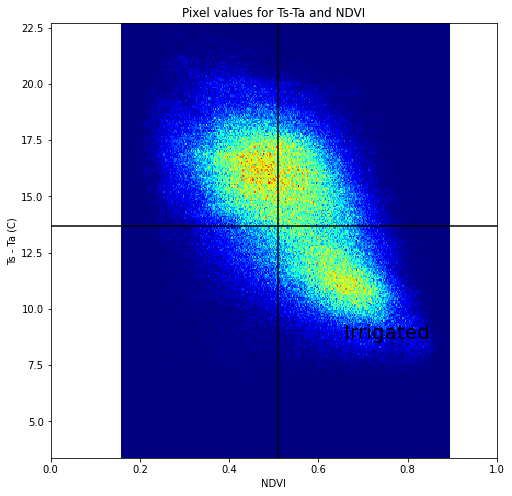

In [18]:
x = ds_ndvi.NDVI.values.flatten()[~np.isnan(ds_ndvi.NDVI.values.flatten())]
y = deltat.values.flatten()[~np.isnan(deltat.values.flatten())]

plt.figure(figsize=(8,8))
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
plt.axhline(delta_threshold, c='black')
plt.axvline(ndvi_threshold, c='black')
plt.text(ndvi_threshold+0.15,delta_threshold-5, 'Irrigated', fontsize=20)
plt.xlim(0,1)
plt.xlabel('NDVI')
plt.ylabel('Ts - Ta (C)')
plt.title('Pixel values for Ts-Ta and NDVI');

## Identify clusters for classification

We have two variables (NDVI and $\Delta T$) that we'd like to use to split dryland and irrigated cropland. We can visualise these in a two-dimensional space to see if there are obvious clusters to split. 

There a many different cluster analysis techniques available. In this case, we'll simply use k-means clustering to identify two clusters (irrigated and rainfed). 

As our two variables have quite different units, we'll need to rescale them before running the cluster analysis. This is shown in the cell below.

In [19]:
# flatten the two predictors into 1-D arrays
ndvi_flat = sklearn_flatten(ds_ndvi.NDVI) 
deltat_flat = sklearn_flatten(deltat)

# combine the two arrays for passing into kmeans
X = np.stack((ndvi_flat,deltat_flat), axis=0).transpose()

# rescale variables for cluster analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# perform kmeans cluster analysis, specifying we are looking for two clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

## Plot the clusters

The plot below shows the values, their density, which cluster they belong to, and the centre values for those clusters. The density shows two distinct clusters which the k-means algorithm has split. We assume to cluster to the bottom-right (higher NDVI and lower $\Delta T$ is the irrigated cropland.

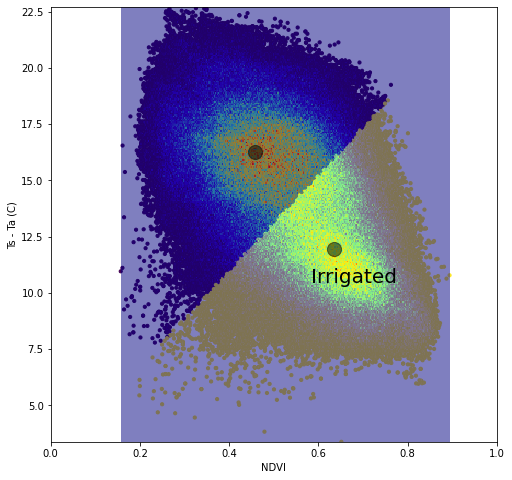

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.hist2d(X[:, 0], X[:, 1], bins=(300, 300), cmap=plt.cm.jet, alpha=0.5)

plt.xlim(0,1)
plt.xlabel('NDVI')
plt.ylabel('Ts - Ta (C)')
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.text(centers[1, 0]-0.05,centers[1, 1]-1.5, 'Irrigated', fontsize=20);

## Apply the cluster analysis to the spatial data

In [21]:
preds_flat = kmeans.predict(X_scaled) # use kmeans to predict which cluster each observation belongs to
preds = sklearn_unflatten(preds_flat, ds_ndvi) # unflatten predictions to return it to spatial dimensions
c = xr.where((cm==1)&(preds == 1), 2, cm) # irrigated (c) where cropland is true and cluster = 0

## Use thresholds to identify irrigation

In [ ]:
#a=ds_ndvi.NDVI.where(ds_ndvi.NDVI>ndvi_threshold)
#b=a.where(deltat<delta_threshold)
#b=xr.where(b>0,1,0)

# add irrigated to cropmask classes
#c = xr.where((cm==1)&(b==1),2,cm)

#b = xr.where((cm==1), 1, 
#c = xr.where((cm==1)&(preds == 0), 2, cm)

Load semi-annual geomedian to compare classification to a true-colour image.

In [22]:
gm = dc.load(product='gm_s2_semiannual', like=cm.geobox, time=time, measurements=['red','green','blue']).squeeze()

### Plot result

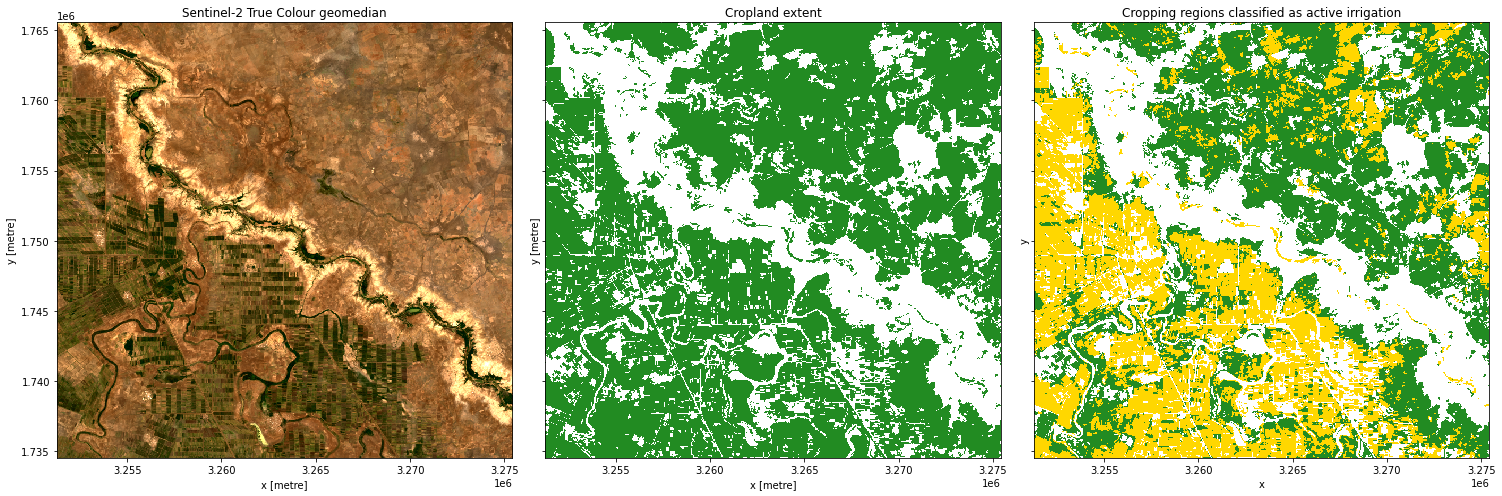

In [23]:
colours = ["white", "forestgreen", "gold"]

fig,ax=plt.subplots(1,3, figsize=(21,7), sharey=True)
rgb(gm, index=1, ax=ax[0])
cm.plot(ax=ax[1], add_colorbar=False, cmap=ListedColormap(colours[0:2]))
c.plot(add_colorbar=False, ax=ax[2], cmap=ListedColormap(colours))
ax[0].set_title('Sentinel-2 True Colour geomedian')
ax[1].set_title('Cropland extent')
ax[2].set_title("Cropping regions classified as active irrigation")
plt.tight_layout();

## Limitations

This method of calculating $\Delta T$ is based on several key assumptions:

* Air temperature is reasonably approximated by ERA5
* Land temperature is reasonably approximated by Landsat 8 Surface Temperature

The cluster based differentiation of irrigated and dryland cropping is reliant on these two features being related these variables. This approach may be less effective in some scenarios, such as:

* Wet seasons where dryland crops are experiencing low levels of moisture stress and high canopy greenness.
* Cold times when $\Delta T$ may not be a good indicator of crop moisture stress.

As always, results should be interpreted with context and care.

## References

Jackson, Ray D., Kustas, William P., and Choudhury, Bhaskar J. 1988. 'A Reexamination of the Crop Water Stress Index'. *Irrig Sci* 9:309-317

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [24]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-16'